# Diet Data Editor
Author: Brent Artuch <br>
Date: 2023-06-04

## Introduction

This notebook depicts the process of adding new food entries to my SQLite database and then takes you
through the macronutrient conversion calculations. After the caloric intake based on macro nutrient for
the day has been calculated, we then proceed to a few visualizations for those calculations. <br>

This document utilizes an array of Pandas processing techniques such as filtering via boolean masking,
using descriptive methods to illustrate the shape of the data set, and creating visualizations using the
data in the dataframe.

# SQL DATABASE CONSTRUCTION IN PROGRESS!!
## Step: 1 Imports
### Import packages

In [1]:
import sqlite3
import pandas as pd
import seaborn as sns

### Load the dataset
This dataset is pulled from a SQLite database that stores all foods I have consumed by `month_YYYY`. We will
load the current month using a simple query.

In [2]:
sql_connection = sqlite3.connect('diet.sqlite')
# Import the desired table and set the index.
current_foods = pd.read_sql(
    '''
    SELECT f.id, d.date, m.meal, f.food_name, f.servings, f.carbs, f.fats, f.proteins, f.calories
    FROM meals m
    INNER JOIN foods f on f.meal_id = m.id
    INNER JOIN dates_2023 d on d.id = m.date_id
    ORDER BY f.id
    ''',
    sql_connection, index_col='id')

current_foods.tail(10)

,date,meal,food_name,servings,carbs,fats,proteins,calories
id,,,,,,,,
86,2023-06-30,Post-Workout,Gordita Crunch,1.0,41,28,20,490
87,2023-06-30,Post-Workout,Steak Ques.,1.0,42,27,26,520
88,2023-06-30,Post-Workout,LG Baja Blast,1.0,111,0,0,420
89,2023-07-01,Breakfast,Ramen,1.0,54,14,8,370
90,2023-07-01,Breakfast,Protein Powder,2.0,3,2,24,120
91,2023-07-01,Lunch,Gordita Crunch,2.0,41,28,20,490
92,2023-07-01,Dinner,Gordita Crunch,1.0,41,28,20,490
93,2023-07-01,Dinner,Fruit Snacks,1.0,17,0,1,70
94,2023-07-01,Post-Workout,Protein Powder,2.0,3,2,24,120


## Step 2: Data Exploration
Next we will get a sense of the size and contents of `current_foods`.

In [3]:
current_foods.shape

(95, 8)

In [4]:
current_foods.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95 entries, 1 to 95
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       95 non-null     object 
 1   meal       95 non-null     object 
 2   food_name  95 non-null     object 
 3   servings   95 non-null     float64
 4   carbs      95 non-null     int64  
 5   fats       95 non-null     int64  
 6   proteins   95 non-null     int64  
 7   calories   95 non-null     int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 6.7+ KB


In [5]:
current_foods[['carbs','fats','proteins','calories']].describe()

,carbs,fats,proteins,calories
count,95.000000,95.000000,95.000000,95.000000
mean,22.673684,7.021053,10.957895,195.052632
std,21.081121,8.810027,13.438525,148.058813
min,0.000000,0.000000,0.000000,70.000000
25%,3.000000,2.000000,1.000000,100.000000
50%,17.000000,3.000000,4.000000,130.000000
75%,41.000000,9.500000,24.000000,206.000000
max,111.000000,41.000000,88.000000,720.000000


In [6]:
current_foods['food_name'].value_counts().head()

Protein Powder    21
Rice              10
Spicy Garlic       9
Fruit Snacks       8
Ramen              5
Name: food_name, dtype: int64

## Step 3: Update the Dataset
### Load the master food list
First we will load the names of the foods from the master `food_list` database so that the algorithm
can check against the list for whether the food reference exists.

In [7]:
# Call the primary food list.
food_db = pd.read_sql('SELECT food_name FROM food_list', sql_connection)
food_db.head()

,food_name
0,Oatmeal
1,Protein Powder
2,Coco Powder
3,Ramen
4,Cereal Bar


### Set the date of the entries

In [8]:
dates_df = pd.read_sql('SELECT * FROM dates_2023', sql_connection, index_col='id')
dates_df.tail()

,date
id,
5,2023-06-27
6,2023-06-28
7,2023-06-29
8,2023-06-30
9,2023-07-01


In [9]:
# Get the date to be added to the dates_2023 table
import datetime

# Autogenerate the year and month
year_month = datetime.datetime.now().strftime("%Y-%m")
day_of_month = input("Enter the day of the month: DD")
date = f"{year_month}-{day_of_month}"
date

'2023-07-01'

In [10]:
# Add date to dates_2023 table
dates_df.loc[len(dates_df)+1, 'date'] = date
dates_df.tail()

,date
id,
6,2023-06-28
7,2023-06-29
8,2023-06-30
9,2023-07-01
10,2023-07-01


In [11]:
dates_df.to_sql('dates_2023', sql_connection, if_exists='replace')

9

In [10]:
meals_df = pd.read_sql('SELECT * FROM meals', sql_connection, index_col='id')
meals_df.tail()

,date_id,meal
id,,
32,8,Post-Workout
33,9,Breakfast
34,9,Lunch
35,9,Dinner
36,9,Post-Workout


In [32]:
# Select the meal of the day
meal_of_day = input("Enter the meal of the day: [1]Breakfast [2]Lunch [3]Dinner [4]Post-Workout")
meal = ''
if meal_of_day == '1':
    meal = 'Breakfast'
elif meal_of_day == '2':
    meal = 'Lunch'
elif meal_of_day == '3':
    meal = 'Dinner'
elif meal_of_day == '4':
    meal = 'Post-Workout'
meal

'Post-Workout'

In [11]:
# Add meal to meals table
meals_df.loc[len(meals_df)+1] = [len(dates_df), meal]
meals_df.loc[len(meals_df), 'date_id'] = len(dates_df)
meals_df.tail()

NameError: name 'meal' is not defined

In [34]:
meals_df.to_sql('meals', sql_connection, if_exists='replace')

36

### Execute the entry insertion algorithm

In [12]:
foods_df = pd.read_sql('SELECT * FROM foods', sql_connection, index_col='id')
foods_df.tail()

,meal_id,food_name,servings,carbs,fats,proteins,calories
id,,,,,,,
91,34,Gordita Crunch,2.0,41,28,20,490
92,35,Gordita Crunch,1.0,41,28,20,490
93,35,Fruit Snacks,1.0,17,0,1,70
94,36,Protein Powder,2.0,3,2,24,120
95,36,Fruit Snacks,1.0,17,0,1,70


In [43]:
# Enter the foods eaten for the selected meal.
choice = 1
foods = list(food_db['food_name'])

while choice != 2:

    """ This algorithm takes a desired food input and then inserts it into a SQL query to
    retrieve the nutritional info for that food. The serving count is then entered and the
    entry is inserted into the dataframe. """

    db_food = input("What food would you like too add?")
    if db_food not in foods:
        raise Exception(input("Food not in database. Try again: "))
    new_food = pd.read_sql("SELECT food_name, carbs, fats, protein, calories"
                            " FROM food_list "
                            " WHERE food_name = (?)", sql_connection, params=(db_food,))

    meal_id = len(meals_df)
    servings = float(input("Enter Serving Count: "))
    new_entry = [
        meal_id,
        new_food.loc[0,'food_name'],
        servings,
        new_food.loc[0,'carbs'],
        new_food.loc[0,'fats'],
        new_food.loc[0,'protein'],
        new_food.loc[0,'calories']
    ]
    foods_df.loc[len(foods_df)+1] = new_entry
    choice = int(input("Add another? [1]Yes [2]No"))

foods_df.tail()

,meal_id,food_name,servings,carbs,fats,proteins,calories
id,,,,,,,
91,34,Gordita Crunch,2.0,41,28,20,490
92,35,Gordita Crunch,1.0,41,28,20,490
93,35,Fruit Snacks,1.0,17,0,1,70
94,36,Protein Powder,2.0,3,2,24,120
95,36,Fruit Snacks,1.0,17,0,1,70


In [44]:
foods_df.to_sql('foods', sql_connection, if_exists='replace')

95

In [45]:
# Back up updated tables as csv files
dates_df.to_csv('datasets/dates.csv')
meals_df.to_csv('datasets/meals.csv')
foods_df.to_csv('datasets/foods.csv')

### Data Manipulation
This section exists for convenience if quick changes need to be made to the entries.

In [13]:
updated_foods = pd.read_sql(
    '''
    SELECT f.id, d.date, m.meal, f.food_name, f.servings, f.carbs, f.fats, f.proteins, f.calories
    FROM meals m
    INNER JOIN foods f on f.meal_id = m.id
    INNER JOIN dates_2023 d on d.id = m.date_id
    ORDER BY f.id
    ''',
    sql_connection)
updated_foods.tail()

,id,date,meal,food_name,servings,carbs,fats,proteins,calories
90,91,2023-07-01,Lunch,Gordita Crunch,2.0,41,28,20,490
91,92,2023-07-01,Dinner,Gordita Crunch,1.0,41,28,20,490
92,93,2023-07-01,Dinner,Fruit Snacks,1.0,17,0,1,70
93,94,2023-07-01,Post-Workout,Protein Powder,2.0,3,2,24,120
94,95,2023-07-01,Post-Workout,Fruit Snacks,1.0,17,0,1,70


## Step 4: Daily Macro Calculations
### Filter out all entries besides those with today's date.

In [14]:
# Sort entries by date
today = updated_foods[updated_foods['date']==date]
today

,id,date,meal,food_name,servings,carbs,fats,proteins,calories
88,89,2023-07-01,Breakfast,Ramen,1.0,54,14,8,370
89,90,2023-07-01,Breakfast,Protein Powder,2.0,3,2,24,120
90,91,2023-07-01,Lunch,Gordita Crunch,2.0,41,28,20,490
91,92,2023-07-01,Dinner,Gordita Crunch,1.0,41,28,20,490
92,93,2023-07-01,Dinner,Fruit Snacks,1.0,17,0,1,70
93,94,2023-07-01,Post-Workout,Protein Powder,2.0,3,2,24,120
94,95,2023-07-01,Post-Workout,Fruit Snacks,1.0,17,0,1,70


### Macro Calculations
These calculations assist in assessing the required macro nutrients for the day and possible adjustments
that need to made if carbs or fats have exceeded or come up short of their targets.

In [15]:
# Calculate macronutrient totals based on serving count
total_carbs = int((today['carbs'] * today['servings']).sum())
total_fats = int((today['fats'] * today['servings']).sum())
total_proteins = int((today['proteins'] * today['servings']).sum())
total_cals = int((today['calories'] * today['servings']).sum())

print(f"Carbs: {total_carbs} | Goals: 525 425 325")
print(f"Fats: {total_fats} | Goals: 100 75 50")
print(f"Protein: {total_proteins} | Goal: 200")
print(f"Calories: {total_cals}")

Carbs: 223 | Goals: 550 450 350
Fats: 106 | Goals: 100 75 50
Protein: 166 | Goal: 200
Calories: 2460


### Convert the macro nutrients to their caloric measurement.

In [18]:
# Calculate the number of calories from each macro nutrient.
carb_cals = total_carbs * 4
fat_cals = total_fats * 9
non_protein_cals = carb_cals + fat_cals
large_goal_npc = (550*4)+(100*9)
small_goal_npc = (450*4)+(75*9)
rest_goal_npc = (350*4)+(50*9)
goal = rest_goal_npc # large_goal_npc OR small_goal_npc OR rest_goal_npc
cal_difference = abs(goal-non_protein_cals)
protein_cals = total_proteins * 4

print(f"Calories From Carbs: {carb_cals}")
print(f"Calories From Fats: {fat_cals}")
print(f"Non-Protein Calories: {non_protein_cals} Goal: {goal}")
print(f"Calorie Difference: {cal_difference}")
print(f"Calories From Protein: {protein_cals}")

Calories From Carbs: 892
Calories From Fats: 954
Non-Protein Calories: 1846 Goal: 1850
Calorie Difference: 4
Calories From Protein: 664


## Step 5: Visualize the Data
Portray the macro nutrient dispersion of calories as a pie chart.

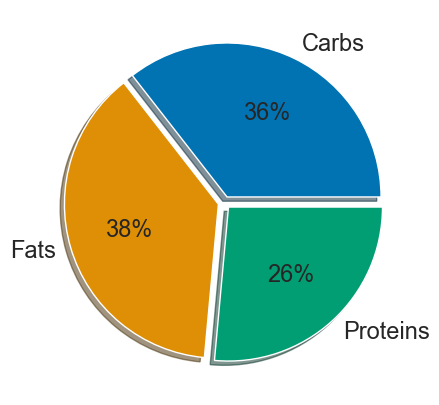

In [19]:
# Plot as a pie chart
macro_series = pd.Series(
    [carb_cals, fat_cals, protein_cals],
    index=['Carbs', 'Fats', 'Proteins'],
    name=""
)

macro_series.plot.pie(
    colors=sns.color_palette('colorblind'),
    autopct='%1.0f%%',
    fontsize=17,
    shadow=True,
    explode=(0.04,0.04,0.04),
    figsize=(5,5)
);

##### Add a new `total_food_cals` column that is the product of the food entry servings by its `calories`.

In [20]:
# Add a total calories column
updated_foods['total_food_cals'] = updated_foods['servings'] * updated_foods['calories']

# Sort entries by date
today = updated_foods[updated_foods['date']==date]
today

,id,date,meal,food_name,servings,carbs,fats,proteins,calories,total_food_cals
88,89,2023-07-01,Breakfast,Ramen,1.0,54,14,8,370,370.0
89,90,2023-07-01,Breakfast,Protein Powder,2.0,3,2,24,120,240.0
90,91,2023-07-01,Lunch,Gordita Crunch,2.0,41,28,20,490,980.0
91,92,2023-07-01,Dinner,Gordita Crunch,1.0,41,28,20,490,490.0
92,93,2023-07-01,Dinner,Fruit Snacks,1.0,17,0,1,70,70.0
93,94,2023-07-01,Post-Workout,Protein Powder,2.0,3,2,24,120,240.0
94,95,2023-07-01,Post-Workout,Fruit Snacks,1.0,17,0,1,70,70.0


##### Group the entries by `meal_number` and aggregate the corresponding `total_food_cals` to get `cals_per_meal`

In [21]:
cals_per_meal = today.groupby(today['meal'], sort=False).aggregate({'total_food_cals': 'sum'})
cals_per_meal.reset_index()
cals_per_meal

,total_food_cals
meal,
Breakfast,610.0
Lunch,980.0
Dinner,560.0
Post-Workout,310.0


### Plot the calories per meal
Ideally the line should be as level as possible over four meals.

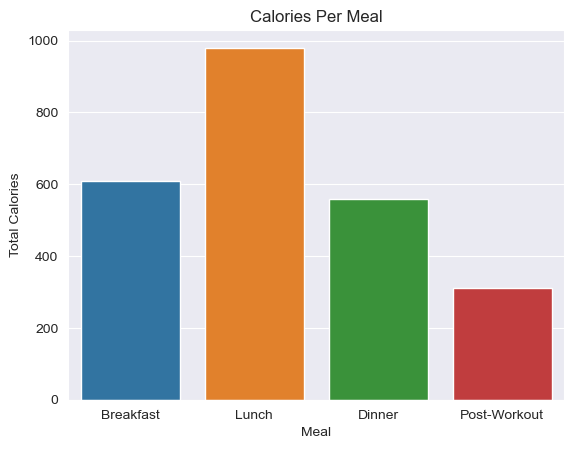

In [22]:
fig = sns.barplot(data=cals_per_meal, x=cals_per_meal.index,y='total_food_cals')
fig.set(title="Calories Per Meal", xlabel="Meal", ylabel="Total Calories");